In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import warnings

from scipy.integrate import quad, dblquad
from tensorflow.examples.tutorials.mnist import input_data

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# config = tf.ConfigProto()

ModuleNotFoundError: No module named 'tensorflow'

In [5]:
def spectral_norm(w, iteration=1):
   w_shape = w.shape.as_list()
   w = tf.reshape(w, [-1, w_shape[-1]])

   u = tf.get_variable("u", [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)

   u_hat = u
   v_hat = None
   for i in range(iteration):
       """
       power iteration
       Usually iteration = 1 will be enough
       """
       v_ = tf.matmul(u_hat, tf.transpose(w))
       v_hat = tf.nn.l2_normalize(v_)

       u_ = tf.matmul(v_hat, w)
       u_hat = tf.nn.l2_normalize(u_)

   u_hat = tf.stop_gradient(u_hat)
   v_hat = tf.stop_gradient(v_hat)

   sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

   with tf.control_dependencies([u.assign(u_hat)]):
       w_norm = w / sigma
       w_norm = tf.reshape(w_norm, w_shape)


   return w_norm

In [6]:
# DEPTH and C_SIZE are chosen to be small for a fast running demo. You will want
# to increase both values for most use cases.
# Further note: this will run *much faster* if you choose a runtime with a GPU
# accelerator.
DEPTH = 5 # number of layers.
C_SIZE = 10 # channel size.
K_SIZE = 3 # kernel size
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
phi = tf.tanh # non-linearity
# phi = tf.identity

# variances of weight and bias. 
# To obtain critical values of the variances of the weights and biases,
# see compute mean field below.  
# mf = MeanField(np.tanh, d_tanh)
# qstar = 1./DEPTH
# W_VAR, B_VAR = mf.sw_sb(qstar, 1)
W_VAR, B_VAR = 1.05, 2.01e-5


def circular_padding(input_, width, kernel_size):
  """Padding input_ for computing circular convolution."""
  begin = kernel_size // 2
  end = kernel_size - 1 - begin
  tmp_up = tf.slice(input_, [0, width - begin, 0, 0], [-1, begin, width, -1])
  tmp_down = tf.slice(input_, [0, 0, 0, 0], [-1, end, width, -1])
  tmp = tf.concat([tmp_up, input_, tmp_down], 1)
  new_width = width + kernel_size - 1
  tmp_left = tf.slice(tmp, [0, 0, width - begin, 0], [-1, new_width, begin, -1])
  tmp_right = tf.slice(tmp, [0, 0, 0, 0], [-1, new_width, end, -1])
  return  tf.concat([tmp_left, tmp, tmp_right], 2)

def conv2d(x, w, strides=1, padding='SAME'):
  return tf.nn.conv2d(x, w, strides=[1, strides, strides, 1], padding=padding)

def get_weight(shape, std=1., name=None):
  return tf.Variable(tf.random_normal(shape, mean=0, stddev=std), name=name)

def get_orthogonal_weight(name, shape, gain=1.):
  # Can also use tf.contrib.framework.convolutional_orthogonal_2d
  return tf.get_variable(name, shape=shape,
     initializer=tf.contrib.framework.convolutional_delta_orthogonal(gain=gain))

def conv_model(x):
  """Convolutional layers. Ouput logits. """
  z = tf.reshape(x, [-1,28,28,1])
  # Increase the channel size to C_SIZE.
  std = np.sqrt(W_VAR / (K_SIZE**2 * 1))
  kernel = get_weight([K_SIZE, K_SIZE, 1, C_SIZE], std=std, name='kernel_0')
  bias = get_weight([C_SIZE], std=np.sqrt(B_VAR), name='bias_0')
  # h = conv2d(z, kernel, strides=1, padding='SAME') + bias
  h = conv2d(z, filter=spectral_norm(kernel), strides=1, padding='SAME') + bias
  z = phi(h)
  
  # Reducing spacial dimension to 7 * 7; applying conv with stride=2 twice.
  std = np.sqrt(W_VAR / (K_SIZE**2 * C_SIZE))
  shape = [K_SIZE, K_SIZE, C_SIZE, C_SIZE]
  for j in range(2):
    kernel = get_weight(shape, std=std, name='reduction_{}_kernel'.format(j))
    bias = get_weight([C_SIZE], std=np.sqrt(B_VAR),
                      name='reduction_{}_bias'.format(j))
    # h = conv2d(z, kernel, strides=2) + bias
    h = conv2d(z, filter=spectral_norm(kernel), strides=2) + bias
    z = phi(h)
  new_width = 7 # width of the current image after dimension reduction. 
  
  # A deep convolution block with depth=DEPTH.
  std = np.sqrt(W_VAR)
  for j in range(DEPTH):
    name = 'block_conv_{}'.format(j)
    kernel_name, bias_name = name + 'kernel', name + 'bias'
    kernel = get_orthogonal_weight(kernel_name, shape, gain=std)
    bias = get_weight([C_SIZE], std=np.sqrt(B_VAR), name=bias_name)
    # z_pad = circular_padding(z, new_width, K_SIZE)
    # h = conv2d(z_pad, kernel, padding='VALID') + bias
    # h = conv2d(z, kernel) + bias
    h = conv2d(z, filter=spectral_norm(kernel)) + bias
    z = phi(h)
  z_ave = tf.reduce_mean(z, [1, 2])
  logit_W = get_weight([C_SIZE, 10], std=np.sqrt(W_VAR/C_SIZE))
  logit_b = get_weight([10], std=B_VAR)
  return tf.matmul(z_ave, logit_W) + logit_b

def loss(logits, labels):
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))

def train_op(loss_, learning_rate, global_step):
  with tf.control_dependencies([tf.assign(global_step, global_step + 1)]):
    return tf.train.MomentumOptimizer(learning_rate, MOMENTUM).minimize(loss_)

def accuracy(logits, labels):
  return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1),
                                         tf.argmax(labels, 1)), 
                                tf.float32))

def run_model(num_steps=1000):
  tf.reset_default_graph()
  accuracy_log = []
  loss_log = []
  x = tf.placeholder(tf.float32, shape=[None, 784])
  y_ = tf.placeholder(tf.float32, shape=[None, 10])
  global_step = tf.train.get_or_create_global_step()
  logits = conv_model(x)
  acc, loss_ = accuracy(logits, y_), loss(logits, y_)
  training = train_op(loss_, LEARNING_RATE, global_step)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_steps):
      batch_xs, batch_ys = mnist.train.next_batch(100)
      # print(batch_xs.min(), batch_xs.max())
      _, acc_value, loss_value, g_step = sess.run(
          [training, acc, loss_, global_step], 
          feed_dict={x:batch_xs, y_:batch_ys})
      accuracy_log.append(acc_value)
      loss_log.append(loss_value)
      if i % (num_steps/100) == 0 or i == num_steps-1:
        print('Step: %5d Accuracy: %.2f Loss: %g'%(g_step, acc_value, loss_value))
  return accuracy_log, loss_log

NameError: name 'tf' is not defined

In [7]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
accuracy_log, loss_log = run_model()


NameError: name 'input_data' is not defined

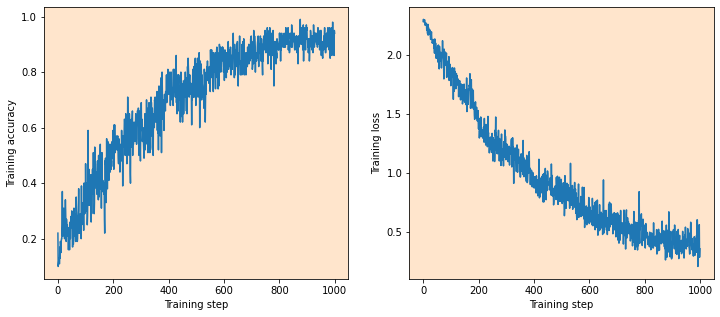

In [4]:
background = [255.0/255.0, 229/255.0, 204/255.0]

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(accuracy_log)
plt.xlabel('Training step')
plt.ylabel('Training accuracy')
plt.gca().set_facecolor(background)

plt.subplot(1,2,2)
plt.plot(loss_log)
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.gca().set_facecolor(background)

In [9]:
w_test = get_orthogonal_weight('w1', [K_SIZE, K_SIZE, C_SIZE, C_SIZE])

In [11]:
import numpy as np
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(w_test.eval())
#     w_test0=w_test.eval()
# np.linalg.svd(w_test0.reshape(-1, C_SIZE))[1]

[[[[ 0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.        ]
   [ 0.          0.          0. 

In [3]:
#========= copy from Xiao ==========
DEPTH = 500
C_SIZE = 128
K_SIZE = 3
LEARNING_RATE = 1e-4
phi = tf.tanh

W_VAR, B_VAR = 1.05, 2.01e-5
print(np.sqrt(W_VAR / (K_SIZE**2 * 1)))
print(np.sqrt(W_VAR / (K_SIZE**2 * C_SIZE)))

def circular_padding(input_, width, kernel_size):
    begin = kernel_size // 2
    end = kernel_size - 1 - begin
    tmp_up = tf.slice(input_, [0, width-begin, 0, 0], [-1, begin, width, -1])
    tmp_down = tf.slice(input_, [0, 0, 0, 0], [-1, end, width, -1])
    tmp = tf.concat([tmp_up, input_, tmp_down], 1)
    new_width = width + kernel_size - 1
    tmp_left = tf.slice(tmp, [0, 0, width-begin, 0], [-1, new_width, begin, -1])
    tmp_right = tf.slice(tmp, [0,0,0,0], [-1, new_width, end, -1])
    return tf.concat([tmp_left, tmp, tmp_right], 2)

def conv2d(x, w, strides=1, padding='SAME'):
    return tf.nn.conv2d(x, w, strides=[1, strides, strides, 1], padding=padding)

def get_weight(shape, std, name=None):
    return tf.Variable(tf.random_normal(shape, mean=0, stddev=std), name=name)

def get_orthogonal_weight(name, shape, std=1):
    return tf.get_variable(name, shape=shape, 
        initializer=tf.contrib.framework.convolutional_delta_orthogonal(gain=std))



0.3415650255319866
0.030190368221227996


In [25]:
def conv_model(x):
    z = tf.reshape(x, [-1, 28, 28, 1])
    std = np.sqrt(W_VAR / (K_SIZE**2 * 1))
    kernel = get_weight([K_SIZE, K_SIZE, 1, C_SIZE], std=std, name='kernel_0')
    bias = get_weight([C_SIZE], std=np.sqrt(B_VAR), name='bias_0')
    h = conv2d(z, kernel, strides=1, padding='SAME') + bias
    z = phi(h)

    std = np.sqrt(W_VAR / (K_SIZE**2 * C_SIZE))
    shape = [K_SIZE, K_SIZE, C_SIZE, C_SIZE]
    for j in range(2):
        kernel = get_weight(shape, std=std, name='reduction_{}_kernel'.format(j))
        bias = get_weight([C_SIZE], std=np.sqrt(B_VAR), name='reduction_{}_bias'.format(j))
        h = conv2d(z, kernel, strides=2) + bias
        z = phi(h)
    new_width = 7

    for j in range(DEPTH):
        name = 'block_conv_{}'.format(j)
        kernel_name, bias_name = name+'kernel', name+'bias'
        kernel = get_orthogonal_weight(kernel_name, shape, std=np.sqrt(W_VAR))
        bias = get_weight([C_SIZE], std=np.sqrt(B_VAR), name=bias_name)
        z_pad = circular_padding(z, new_width, K_SIZE)
        h = conv2d(z_pad, kernel, padding='VALID') + bias
        z = phi(h)
    z_ave = tf.reduce_mean(z, [1, 2])
    weight_to_classes = get_weight([C_SIZE, 10], np.sqrt(W_VAR/C_SIZE))
    return tf.matmul(z_ave, weight_to_classes) + get_weight([10], np.sqrt(B_VAR))

def loss(logits, labels):
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
    )

def train_op(loss_, learning_rate, global_step):
    with tf.control_dependencies([tf.assign(global_step, global_step+1)]):
        return tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss_)

def accuracy(logits, labels):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1),
                                           tf.argmax(labels, 1)),
                                  tf.float32))

In [26]:
def run_model(num_steps=1000):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    global_step = tf.train.get_or_create_global_step()
    logits = conv_model(x)
    acc, loss_ = accuracy(logits, y_), loss(logits, y_)
    training = train_op(loss_, LEARNING_RATE, global_step)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(num_steps):
            batch_xs, batch_ys = mnist.train.next_batch(100)
            _, acc_value, loss_value, g_step = sess.run(
                [training, acc, loss_, global_step],
                feed_dict={x:batch_xs, y_:batch_ys})
            if i % 10 == 0:
                print('Step: %5d Accuracy: %.2f Loss: %g'%(g_step, acc_value, loss_value))
    return accuracy_log, loss_log

In [27]:
run_model()

Step:     0 Accuracy: 0.16 Loss: 2.30434
Step:    10 Accuracy: 0.15 Loss: 2.27936
Step:    20 Accuracy: 0.25 Loss: 2.26285
Step:    30 Accuracy: 0.29 Loss: 2.21747
Step:    40 Accuracy: 0.36 Loss: 2.10611
Step:    50 Accuracy: 0.15 Loss: 2.12405
Step:    60 Accuracy: 0.31 Loss: 2.00064
Step:    70 Accuracy: 0.29 Loss: 2.00193
Step:    80 Accuracy: 0.26 Loss: 1.94047
Step:    90 Accuracy: 0.39 Loss: 1.85745
Step:   100 Accuracy: 0.35 Loss: 1.89843
Step:   110 Accuracy: 0.38 Loss: 1.77499
Step:   120 Accuracy: 0.23 Loss: 1.94978
Step:   130 Accuracy: 0.52 Loss: 1.6062
Step:   140 Accuracy: 0.43 Loss: 1.689
Step:   150 Accuracy: 0.37 Loss: 1.63361
Step:   160 Accuracy: 0.38 Loss: 1.63475
Step:   170 Accuracy: 0.49 Loss: 1.49732
Step:   180 Accuracy: 0.49 Loss: 1.46555
Step:   190 Accuracy: 0.51 Loss: 1.52127
Step:   200 Accuracy: 0.58 Loss: 1.38001
Step:   210 Accuracy: 0.42 Loss: 1.47888
Step:   220 Accuracy: 0.55 Loss: 1.32273
Step:   230 Accuracy: 0.48 Loss: 1.40728
Step:   240 Accurac

NameError: name 'accuracy_log' is not defined